# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/final.sqlite" "final.sqlite"

In [0]:
import os
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
print("Preprocessed Amzon fine food data columns  shape : ",final.shape)
print("fPreprocessed Amzon fine food data columns       :",final.columns.values)

Preprocessed Amzon fine food data columns  shape :  (364171, 12)
fPreprocessed Amzon fine food data columns       : ['index' 'Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [0]:
print(final['CleanedText'][0])
print(final['Text'][0])

this witti littl book make son laugh loud recit the car were drive along and alway can sing the refrain hes learn about whale india droop love all the new word this book introduc and the silli all this classic book will bet son will still abl recit from memori when colleg
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW


preprocessed_reviews=final['CleanedText'][:10]

count_vect = CountVectorizer(max_features=20) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])



final_counts.toarray()

some feature names  ['and', 'book', 'can', 'children', 'for', 'from', 'it', 'kid', 'learn', 'littl']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10, 20)
the number of unique words  20


array([[2, 3, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 4, 0, 3, 2, 0],
       [3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 4, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 4, 1, 1, 1, 0],
       [3, 2, 0, 0, 1, 2, 0, 1, 0, 3, 0, 1, 0, 1, 1, 6, 2, 2, 1, 1],
       [3, 4, 1, 2, 1, 0, 0, 0, 3, 1, 1, 4, 2, 1, 0, 7, 0, 4, 0, 1],
       [4, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0, 1],
       [2, 4, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 3, 0, 5, 0, 5, 0, 0],
       [3, 1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 2],
       [3, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]])

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

preprocessed_reviews=final['CleanedText'][:100000]
score=final['Score'][:100000]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, score, test_size=0.2, random_state=42)

X_train.shape


(80000,)

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, score, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=10000)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)



(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
After vectorizations
(44890, 10000) (44890,)
(22110, 10000) (22110,)
(33000, 10000) (33000,)


In [0]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    #y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    #y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
        print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_bow[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    


train auc :: [1.0, 0.9170594286878491, 0.8771472557173929, 0.8590538943031316, 0.8465512945244734, 0.8358748846247497, 0.8276945401984872, 0.8236572900971406]
cv auc :: [0.5792912197913775, 0.6827606012225214, 0.7195315137549314, 0.7379474941372506, 0.7494888006184072, 0.7623081236818976, 0.7692754052617244, 0.7764162758825128]


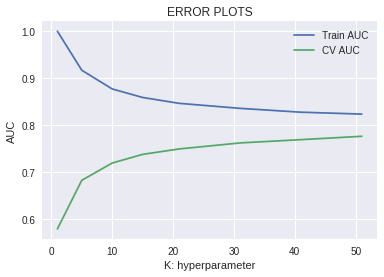

In [0]:
print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='brute',n_neighbors=50)
clf1.fit(X_train_bow,y_train)

#pred_train = []
#for i in range(0, X_train.shape[0], 1000):
#   print(i)
#   pred_train.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1]) 

#pred = []
#for i in range(0, X_train.shape[0], 1000):
#   print(i)
#   pred.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1])


pred_train=clf1.predict(X_train_bow)
pred=clf1.predict(X_test_bow)



In [0]:

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_bow)
pred_proba_train=clf1.predict_proba(X_train_bow)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()

#pred_proba=clf1.predict_proba(X_test_bow)
print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))



Accuracy Score :  85.25151515151515
Precision Score :  85.25862591716694
Recall Score :  99.98222222222222
F1 Score :  92.0352823735415
        
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.00      0.01      4875
           1       0.85      1.00      0.92     28125

   micro avg       0.85      0.85      0.85     33000
   macro avg       0.79      0.50      0.46     33000
weighted avg       0.83      0.85      0.79     33000

        
AUC Score for train data : 0.5026992908774123
AUC Score for test data : 0.5012444444444445
        
AUC Score for train data : 0.8241680277551859
AUC Score for test data : 0.7649976961823362
        
RoC predict 0.5012444444444445
RoC predictproba 0.7649976961823362


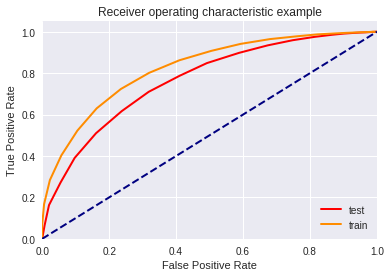

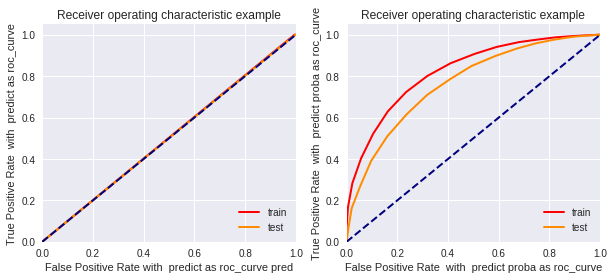

       

TrueNegative : 13
FalsePostive : 4862
FalseNegative : 5
TruePostive  :  28120
        
        


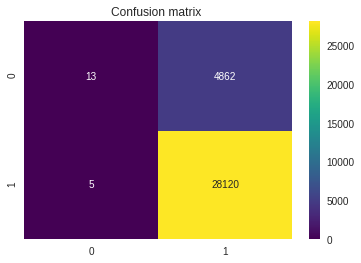

In [0]:
plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [0]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=0.95,stop_words='english',max_features=10000 )
tf_idf_vect.fit(X_train) # fit has to happen only on train data
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
some sample features(unique words in the corpus) ['abil', 'abl', 'abl buy', 'abl eat', 'abl enjoy', 'abl local', 'abl make', 'abl order', 'abl purchas', 'abl tell']
After vectorizations
(44890, 10000) (44890,)
(22110, 10000) (22110,)
(33000, 10000) (33000,)


In [0]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf=KNeighborsClassifier(algorithm='brute')
param_grid={'n_neighbors' : np.arange(5,25) }
gcv=GridSearchCV(clf,param_grid,cv=10,scoring='roc_auc')
gcv.fit(X_train_tfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)
        
optimal_n_neighbors          =  gcv.best_params_['n_neighbors']
#optimal_estimators     =  gcv.best_params_['n_estimators']

In [0]:
hyperparameters=[i['n_neighbors'] for i in gcv.cv_results_['params']]


train_score = gcv.cv_results_['mean_train_score'].tolist()
test_score  = gcv.cv_results_['mean_test_score'].tolist()

train_score=  list(map(lambda x : round(x,2)*100,train_score))
test_score=  list(map(lambda x : round(x,2)*100,test_score))

print(hyperparameters)
print(train_score)
print(test_score)


plt.plot( hyperparameters ,train_score , label='Train plot')
plt.plot( hyperparameters ,test_score ,  label='Test plot')
plt.xlabel("hyper_parameters (K)")
plt.ylabel("Model performance")

plt.legend()

************************************************************
n_neighbors is 1
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 5
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 10
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 15
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 21
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 31
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 41
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 51
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 61
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 71
y_tra

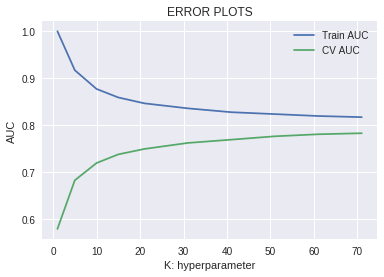

In [0]:

from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51 ,61 , 71]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    #y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    #y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
        #print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_tfidf[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_tfidf[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    
    #train_auc.append(roc_auc_score(y_train,y_train_pred))
    #cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='brute',n_neighbors=70)
clf1.fit(X_train_tfidf,y_train)

pred_train=clf1.predict(X_train_tfidf)
pred=clf1.predict(X_test_tfidf)

In [0]:
print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_tfidf)
pred_proba_train=clf1.predict_proba(X_train_tfidf)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()

#pred_proba=clf1.predict_proba(X_test_bow)
print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))

Accuracy Score :  85.23939393939393
Precision Score :  85.2418768186227
Recall Score :  99.99288888888888
F1 Score :  92.03004074152854
        
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.00      0.00      4875
           1       0.85      1.00      0.92     28125

   micro avg       0.85      0.85      0.85     33000
   macro avg       0.80      0.50      0.46     33000
weighted avg       0.84      0.85      0.78     33000

        
AUC Score for train data : 0.5011676141128613
AUC Score for test data : 0.500579829059829
        
AUC Score for train data : 0.8176315422354804
AUC Score for test data : 0.7722402935612536
        
RoC predict 0.500579829059829
RoC predictproba 0.7722402935612536


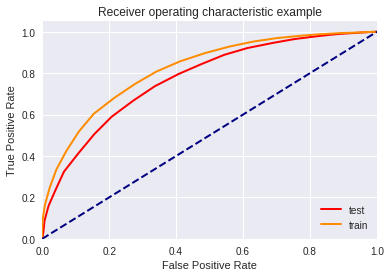

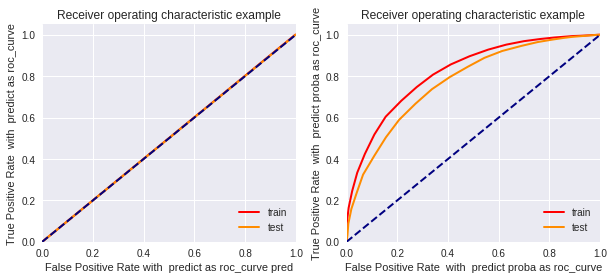

       

TrueNegative : 6
FalsePostive : 4869
FalseNegative : 2
TruePostive  :  28123
        
        


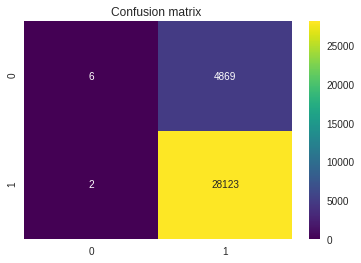

In [0]:
plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())
	
	
#*******************************************************************************************

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
		
#*******************************************************************************************

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_train_AvgW2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_AvgW2V.append(sent_vec)
print(len(X_train_AvgW2V))
print(len(X_train_AvgW2V[0]))
#*********************************************************************************************


  0%|          | 85/44890 [00:00<00:52, 846.95it/s]

[('fantast', 0.8377578258514404), ('awesom', 0.8363084197044373), ('good', 0.8219577074050903), ('excel', 0.8158608078956604), ('wonder', 0.812054455280304), ('terrif', 0.8055641055107117), ('perfect', 0.7771304845809937), ('nice', 0.7103393077850342), ('decent', 0.6950829029083252), ('fabul', 0.688372790813446)]
[('best', 0.7759975790977478), ('greatest', 0.7759384512901306), ('tastiest', 0.7052741646766663), ('closest', 0.6956551671028137), ('disgust', 0.5752589106559753), ('weirdest', 0.5443143248558044), ('horribl', 0.544090747833252), ('hottest', 0.5419071316719055), ('superior', 0.5384922027587891), ('finest', 0.5339829325675964)]
number of words that occured minimum 5 times  9254
sample words  ['veri', 'crunchi', 'ginger', 'snap', 'with', 'just', 'the', 'right', 'amount', 'zing', 'versitil', 'cooki', 'pie', 'crust', 'top', 'eat', 'out', 'excel', 'wheat', 'free', 'altern', 'for', 'those', 'miss', 'good', 'old', 'crunch', 'spici', 'have', 'friend', 'celiac', 'diseas', 'like', 'fin

100%|██████████| 44890/44890 [01:10<00:00, 638.61it/s]

44890
50


In [0]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
	
#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_cv_AvgW2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_AvgW2V.append(sent_vec)
print(len(X_cv_AvgW2V))
print(len(X_cv_AvgW2V[0]))




#********************************************************************************************


i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
	
#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_test_AvgW2V = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_AvgW2V.append(sent_vec)
print(len(X_test_AvgW2V))
print(len(X_test_AvgW2V[0]))


100%|██████████| 22110/22110 [00:34<00:00, 632.08it/s]


22110
50


100%|██████████| 33000/33000 [00:51<00:00, 634.91it/s]

33000
50


************************************************************
n_neighbors is 1
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 5
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 10
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 15
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 21
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 31
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 41
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 51
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 61
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 71
y_tra

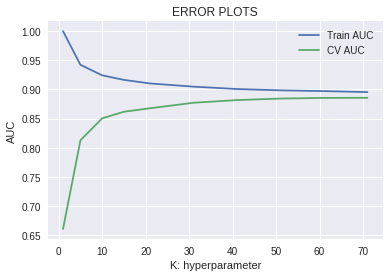

In [0]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51 ,61 , 71]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_AvgW2V, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    #y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    #y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
       # print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_AvgW2V[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_AvgW2V[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    
    #train_auc.append(roc_auc_score(y_train,y_train_pred))
    #cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [0]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='brute',n_neighbors=70)
clf1.fit(X_train_AvgW2V,y_train)



pred_train=clf1.predict(X_train_AvgW2V)
pred=clf1.predict(X_test_AvgW2V)



In [0]:

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_AvgW2V)
pred_proba_train=clf1.predict_proba(X_train_AvgW2V)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()

#pred_proba=clf1.predict_proba(X_test_bow)
print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))



Accuracy Score :  87.4121212121212
Precision Score :  87.89641761785816
Recall Score :  98.84088888888888
F1 Score :  93.0479314499933
        
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.21      0.34      4875
           1       0.88      0.99      0.93     28125

   micro avg       0.87      0.87      0.87     33000
   macro avg       0.82      0.60      0.63     33000
weighted avg       0.86      0.87      0.84     33000

        
AUC Score for train data : 0.6050499079239432
AUC Score for test data : 0.6015890598290599
        
AUC Score for train data : 0.8958205967950382
AUC Score for test data : 0.881415865982906
        
RoC predict 0.6015890598290599
RoC predictproba 0.881415865982906


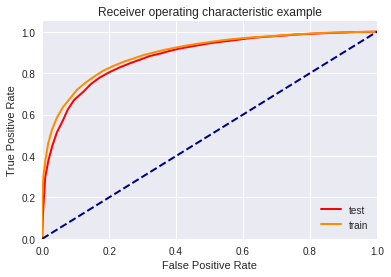

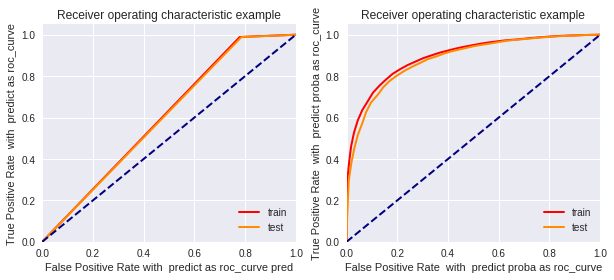

       

TrueNegative : 1047
FalsePostive : 3828
FalseNegative : 326
TruePostive  :  27799
        
        


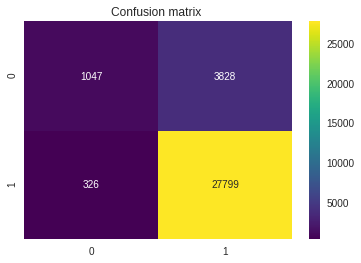

In [0]:
plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

#*********************************************************************************************

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_Avgtfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_Avgtfidf.append(sent_vec)
    row += 1

print("completed X_train_Avgtfidf")    
#********************************************************************************************

X_cv_Avgtfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_cv_Avgtfidf.append(sent_vec)
    row += 1

    
print("completed X_cv_Avgtfidf")     
#*********************************************************************************************

X_test_Avgtfidf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_Avgtfidf.append(sent_vec)
    row += 1

    
    
print("completed X_cv_Avgtfidf") 

completed X_train_Avgtfidf
completed X_cv_Avgtfidf
completed X_cv_Avgtfidf


In [0]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51 ,61 , 71]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    neigh.fit(X_train_Avgtfidf, y_train)
   
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
        #print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_Avgtfidf[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_Avgtfidf[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

************************************************************
n_neighbors is 1
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 5
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 10
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 15
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 21
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 31
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 41
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 51
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 61
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 71
y_tra

train auc :: [1.0, 0.9295722349032395, 0.9075585922928312, 0.8961909519373178, 0.8901474542779543, 0.8826420664516172, 0.8785870206057338, 0.8753365616844556, 0.8737223660958421, 0.8720661727954907]
cv auc :: [0.6512223307946281, 0.7797871698277299, 0.813658359876479, 0.8308986292323868, 0.843568253122367, 0.8508150558659655, 0.8534294066366395, 0.8559349655496259, 0.8565197564707732, 0.8569715079266417]


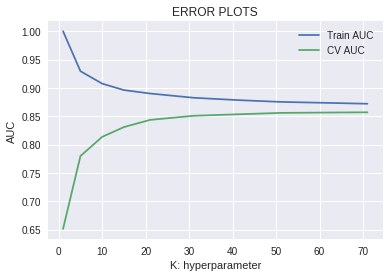

In [0]:
print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='brute',n_neighbors=70)
clf1.fit(X_train_Avgtfidf,y_train)


pred_train=clf1.predict(X_train_Avgtfidf)
pred=clf1.predict(X_test_Avgtfidf)

In [0]:
print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_Avgtfidf)
pred_proba_train=clf1.predict_proba(X_train_Avgtfidf)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))

Accuracy Score :  87.03939393939393
Precision Score :  87.38325055446225
Recall Score :  99.15638735289947
F1 Score :  92.89829804898298
        
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.16      0.26      4788
           1       0.87      0.99      0.93     28212

   micro avg       0.87      0.87      0.87     33000
   macro avg       0.82      0.57      0.59     33000
weighted avg       0.86      0.87      0.83     33000

        
AUC Score for train data : 0.580700354220822
AUC Score for test data : 0.5739983110335032
        
AUC Score for train data : 0.8722849256558325
AUC Score for test data : 0.8518701411416437
        
RoC predict 0.5739983110335032
RoC predictproba 0.8518701411416437


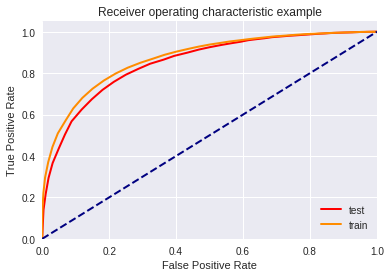

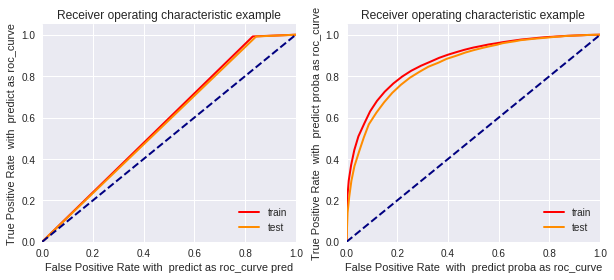

       

TrueNegative : 749
FalsePostive : 4039
FalseNegative : 238
TruePostive  :  27974
        
        


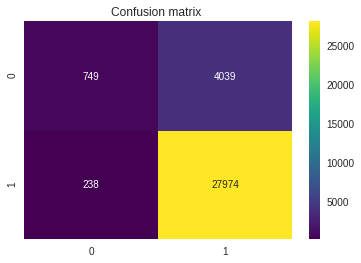

In [0]:

plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=10, max_features=500,stop_words='english')
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


In [0]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 21, 31, 41, 51 ,61 , 71]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_bow, y_train)
    
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
        #print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_bow[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_bow[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

************************************************************
n_neighbors is 1
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 5
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 10
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 21
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 31
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 41
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 51
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 61
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 71
y_train_pred
y_cv_pred


train auc :: [0.9998522240283729, 0.9018953978776072, 0.866779289041168, 0.8426659178337765, 0.8316293285256843, 0.8285158539724078, 0.8257829656327621, 0.822712341575993, 0.8213075976792952]
cv auc :: [0.6113587579061401, 0.7051344745710744, 0.7431618563635385, 0.7626174805157292, 0.7713400982662251, 0.7758903646422317, 0.7787737895881574, 0.7820069154731827, 0.7843058188251406]


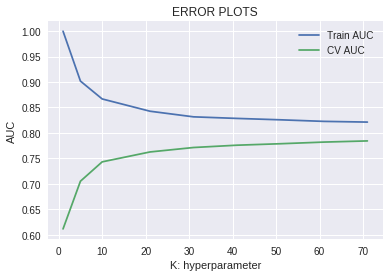

In [0]:
print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=70)
clf1.fit(X_train_bow,y_train)

pred_train=clf1.predict(X_train_bow)
pred=clf1.predict(X_test_bow)

In [0]:
print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_bow)
pred_proba_train=clf1.predict_proba(X_train_bow)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  


print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))

Accuracy Score :  85.66969696969697
Precision Score :  85.69170441073655
Recall Score :  99.9220189990075
F1 Score :  92.26136902911192
        
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.02      0.03      4788
           1       0.86      1.00      0.92     28212

   micro avg       0.86      0.86      0.86     33000
   macro avg       0.82      0.51      0.48     33000
weighted avg       0.85      0.86      0.79     33000

        
AUC Score for train data : 0.5081561168733929
AUC Score for test data : 0.5080687416115789
        
AUC Score for train data : 0.8213048222525007
AUC Score for test data : 0.7861363829785722
        
RoC predict 0.5080687416115789
RoC predictproba 0.7861363829785722


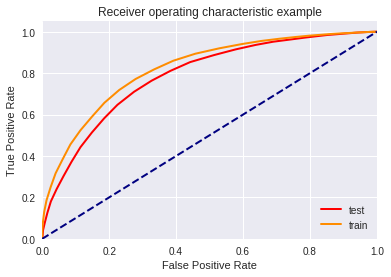

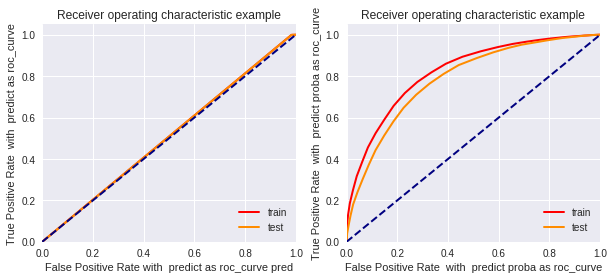

       

TrueNegative : 81
FalsePostive : 4707
FalseNegative : 22
TruePostive  :  28190
        
        


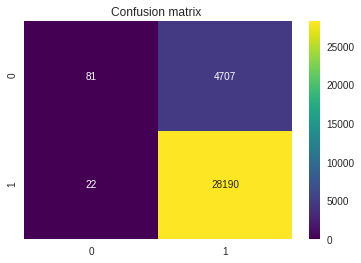

In [0]:

plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=0.95,stop_words='english',max_features=500 )
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
some sample features(unique words in the corpus) ['abl', 'absolut', 'actual', 'ad', 'add', 'addict', 'addit', 'ago', 'alreadi', 'altern']
After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


In [0]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51 ,61 , 71]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_tfidf, y_train)
   
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
        #print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_tfidf[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_tfidf[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

************************************************************
n_neighbors is 1
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 5
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 10
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 15
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 21
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 31
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 41
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 51
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 61
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 71
y_tra

train auc :: [0.9998522240283729, 0.9018953978776072, 0.866779289041168, 0.851015357138063, 0.8426659178337765, 0.8316293285256843, 0.8285158539724078, 0.8257829656327621, 0.822712341575993, 0.8213075976792952]
cv auc :: [0.6113587579061401, 0.7051344745710744, 0.7431618563635385, 0.7550994000108645, 0.7626174805157292, 0.7713400982662251, 0.7758903646422317, 0.7787737895881574, 0.7820069154731827, 0.7843058188251406]


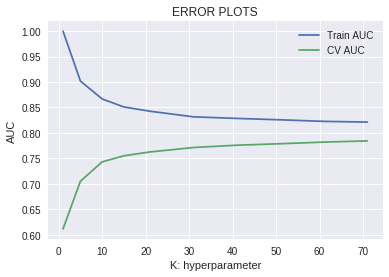

In [0]:
print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=50)
clf1.fit(X_train_tfidf,y_train)

pred_train=clf1.predict(X_train_tfidf)
pred=clf1.predict(X_test_tfidf)


In [0]:
print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_bow)
pred_proba_train=clf1.predict_proba(X_train_bow)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()

#pred_proba=clf1.predict_proba(X_test_bow)
print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))

Accuracy Score :  85.75151515151515
Precision Score :  85.80348440545808
Recall Score :  99.85467177087764
F1 Score :  92.2973592818295
        
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.03      0.05      4788
           1       0.86      1.00      0.92     28212

   micro avg       0.86      0.86      0.86     33000
   macro avg       0.81      0.51      0.49     33000
weighted avg       0.84      0.86      0.80     33000

        
AUC Score for train data : 0.5144339985502892
AUC Score for test data : 0.512535681327237
        
AUC Score for train data : 0.8262006712416219
AUC Score for test data : 0.7815081710372628
        
RoC predict 0.512535681327237
RoC predictproba 0.7815081710372628


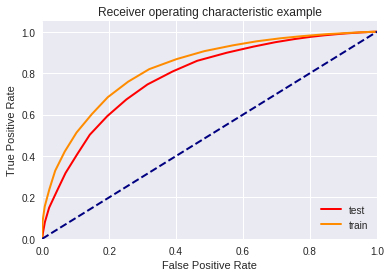

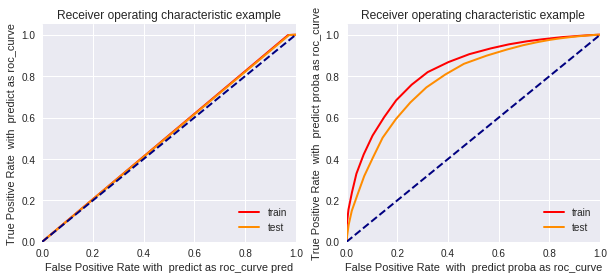

       

TrueNegative : 127
FalsePostive : 4661
FalseNegative : 41
TruePostive  :  28171
        
        


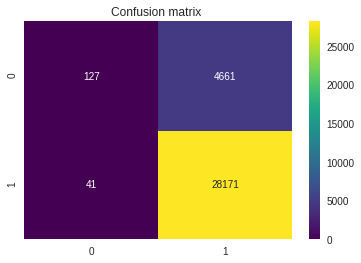

In [0]:
plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

************************************************************
n_neighbors is 1
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 5
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 10
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 21
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 31
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 41
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 51
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 61
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 71
y_train_pred
y_cv_pred
train auc :: [1.0, 0.9421406252860584, 0.9230518096090867, 0.9109605445520715, 0.904

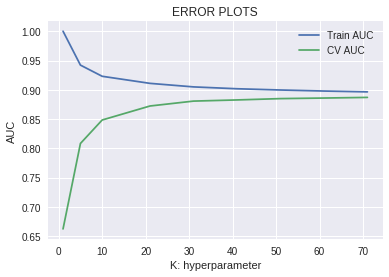

In [0]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 21, 31, 41, 51 ,61 , 71]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_AvgW2V, y_train)
    
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
       # print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_AvgW2V[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_AvgW2V[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    
    #train_auc.append(roc_auc_score(y_train,y_train_pred))
    #cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


Accuracy Score :  87.62424242424242
Precision Score :  88.1169036334913
Recall Score :  98.85509712179214
F1 Score :  93.17764190972571
        
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.21      0.33      4788
           1       0.88      0.99      0.93     28212

   micro avg       0.88      0.88      0.88     33000
   macro avg       0.82      0.60      0.63     33000
weighted avg       0.86      0.88      0.85     33000

        
AUC Score for train data : 0.6106482326746957
AUC Score for test data : 0.6015227704878245
        
AUC Score for train data : 0.8965571997379423
AUC Score for test data : 0.8778980066310206
        
RoC predict 0.6015227704878245
RoC predictproba 0.8778980066310206


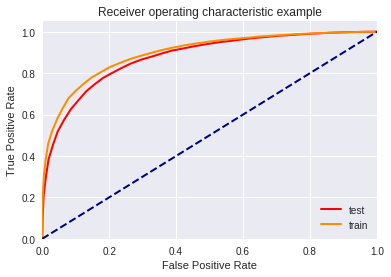

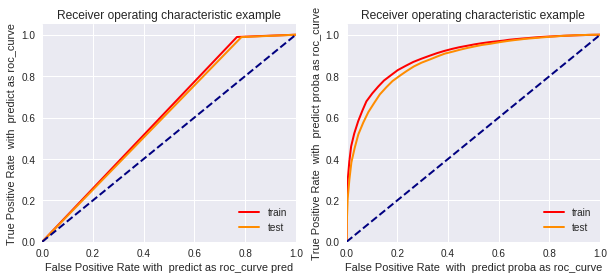

       

TrueNegative : 1027
FalsePostive : 3761
FalseNegative : 323
TruePostive  :  27889
        
        


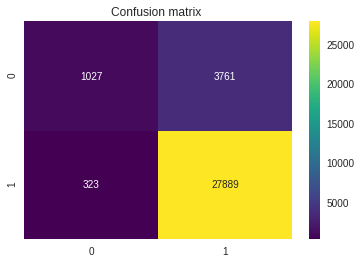

In [0]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=70)
clf1.fit(X_train_AvgW2V,y_train)



pred_train=clf1.predict(X_train_AvgW2V)
pred=clf1.predict(X_test_AvgW2V)




print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_AvgW2V)
pred_proba_train=clf1.predict_proba(X_train_AvgW2V)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()

#pred_proba=clf1.predict_proba(X_test_bow)
print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))




plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51 ,61 , 71]
for i in K:
    print("**********"*6)
    print("n_neighbors is {}".format(i))
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    neigh.fit(X_train_Avgtfidf, y_train)
   
    print("y_train_pred")
    y_train_pred = []
    for i in range(0, X_train.shape[0], 1000):
        #print(i)
        y_train_pred.extend(neigh.predict_proba(X_train_Avgtfidf[i:i+1000])[:,1]) # this is a pseudo code
    
    print("y_cv_pred")
    y_cv_pred = []
    for i in range(0, X_cv.shape[0], 1000):
        y_cv_pred.extend(neigh.predict_proba(X_cv_Avgtfidf[i:i+1000])[:,1]) # this is a pseudo code

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

************************************************************
n_neighbors is 1
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 5
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 10
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 15
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 21
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 31
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 41
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 51
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 61
y_train_pred
y_cv_pred
************************************************************
n_neighbors is 71
y_tra

train auc :: [1.0, 0.9295722349032395, 0.9075585922928312, 0.8961909519373178, 0.8901474542779543, 0.8826420664516172, 0.8785870206057338, 0.8753365616844556, 0.8737223660958421, 0.8720661727954907]
cv auc :: [0.6512223307946281, 0.7797871698277299, 0.813658359876479, 0.8308986292323868, 0.843568253122367, 0.8508150558659655, 0.8534294066366395, 0.8559349655496259, 0.8565197564707732, 0.8569715079266417]


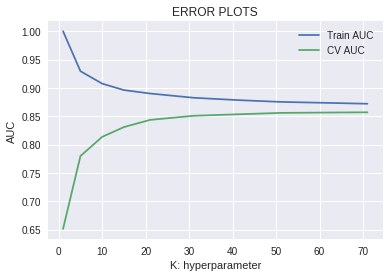

In [0]:
print("train auc :: {}".format(train_auc))
print("cv auc :: {}".format(cv_auc))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


clf1=KNeighborsClassifier(algorithm='kd_tree',n_neighbors=70)
clf1.fit(X_train_Avgtfidf,y_train)


pred_train=clf1.predict(X_train_Avgtfidf)
pred=clf1.predict(X_test_Avgtfidf)


In [0]:

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train_pred,tpr_train_pred,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train_pred,tpr_train_pred))

fpr_pred,tpr_pred,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr_pred,tpr_pred))

print("        ")  

pred_proba=clf1.predict_proba(X_test_Avgtfidf)
pred_proba_train=clf1.predict_proba(X_train_Avgtfidf)

fpr_train_pred_proba,tpr_train_pred_proba,thresholds_train=roc_curve(y_train,pred_proba_train[:,1])
print("AUC Score for train data :",metrics.auc(fpr_train_pred_proba,tpr_train_pred_proba))

fpr_pred_proba,tpr_pred_proba,thresholds=roc_curve(y_test,pred_proba[:,1])
print("AUC Score for test data :",metrics.auc(fpr_pred_proba,tpr_pred_proba))


print("        ")  

print("RoC predict",roc_auc_score(y_test, pred))

print("RoC predictproba",roc_auc_score(y_test, pred_proba[:,1]))





Accuracy Score :  87.03939393939393
Precision Score :  87.38325055446225
Recall Score :  99.15638735289947
F1 Score :  92.89829804898298
        
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.16      0.26      4788
           1       0.87      0.99      0.93     28212

   micro avg       0.87      0.87      0.87     33000
   macro avg       0.82      0.57      0.59     33000
weighted avg       0.86      0.87      0.83     33000

        
AUC Score for train data : 0.580700354220822
AUC Score for test data : 0.5739983110335032
        
AUC Score for train data : 0.8722849256558325
AUC Score for test data : 0.8518701411416437
        
RoC predict 0.5739983110335032
RoC predictproba 0.8518701411416437


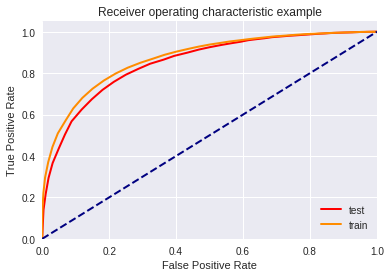

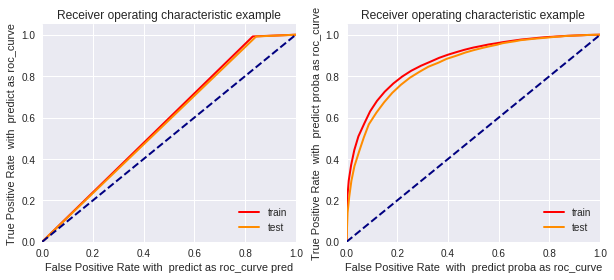

       

TrueNegative : 749
FalsePostive : 4039
FalseNegative : 238
TruePostive  :  27974
        
        


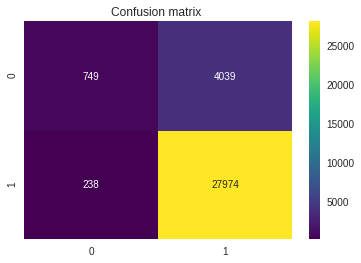

In [0]:
plt.figure()
lw = 2
plt.plot(fpr_pred_proba, tpr_pred_proba, color='red',
         lw=lw,label='test')
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(fpr_train_pred, tpr_train_pred,color='red',lw=2,label='train')
plt.plot(fpr_pred, tpr_pred,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate with  predict as roc_curve pred')
plt.ylabel('True Positive Rate  with  predict as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr_train_pred_proba, tpr_train_pred_proba,color='red',lw=2,label='train')
plt.plot(fpr_pred_proba, tpr_pred_proba,color='darkorange',lw=2,label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate  with  predict proba as roc_curve')
plt.ylabel('True Positive Rate  with  predict proba as roc_curve')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()




print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


# [6] Conclusions

In [0]:
from prettytable import PrettyTable

In [3]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["KNN with Different Vectorization", "Algo" , 'Test_Accuracy','F1-Score','AUC_Score on TestData']


x.add_row([ "KNN with BOW" , "Brute" , 85.2515  , 92.035  ,  76.499  ])
x.add_row([ "KNN with TFIDF" , "Brute" , 85.2393  , 92.03  ,  77.224 ])
x.add_row([ "KNN with AVG_W2V" , "Brute" , 87.412  , 93.04  ,  88.141 ])
x.add_row([ "KNN with AVG_TFIDF" , "Brute" , 87.039  , 92.89  ,  85.187  ])

x.add_row([ "KNN with BOW" , "kd_tree" , 85.669 , 92.26 ,  78.613  ])
x.add_row([ "KNN with TFIDF" , "kd_tree" , 85.75  , 92.29  ,  78.153 ])
x.add_row([ "KNN with AVG_W2V" , "kd_tree" , 87.62  , 93.177 , 87.789])
x.add_row([ "KNN with AVG_TFIDF" , "kd_tree" ,87.039 , 92.89 ,  85.187  ])




print(x)

+----------------------------------+---------+---------------+----------+-----------------------+
| KNN with Different Vectorization |   Algo  | Test_Accuracy | F1-Score | AUC_Score on TestData |
+----------------------------------+---------+---------------+----------+-----------------------+
|           KNN with BOW           |  Brute  |    85.2515    |  92.035  |         76.499        |
|          KNN with TFIDF          |  Brute  |    85.2393    |  92.03   |         77.224        |
|         KNN with AVG_W2V         |  Brute  |     87.412    |  93.04   |         88.141        |
|        KNN with AVG_TFIDF        |  Brute  |     87.039    |  92.89   |         85.187        |
|           KNN with BOW           | kd_tree |     85.669    |  92.26   |         78.613        |
|          KNN with TFIDF          | kd_tree |     85.75     |  92.29   |         78.153        |
|         KNN with AVG_W2V         | kd_tree |     87.62     |  93.177  |         87.789        |
|        KNN with AV